In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
from torch.nn.parameter import Parameter
from torch import Tensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tarfile
import os
import csv
import shutil

In [45]:
class LP_ReLU1(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(LP_ReLU1, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        self.weight.data.uniform_(-0.1, 0.1)
        if bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [80]:
# define new activation function
class LP_ReLU1(nn.Module):
    
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(LP_ReLU1,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(6.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha
            
        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x:Tensor)->Tensor:
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        x=x.clone().detach().requires_grad_(True)
        print(x.shape)
        out = 0
        if (x <= 0):
            return 0

        if (x <= self.alpha and x > 0):
            return x

        if (x > self.alpha):
            return (self.alpha + 0.05*(x - self.alpha))




# testing
acti = LP_ReLU1(64)

In [3]:
from torch.functional import Tensor
# define new activation function
class LP_ReLU2(nn.Module):
    
    def __init__(self, in_features, alpha = None, beta = None):
        
        super(LP_ReLU2,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(5.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha

        if beta == None:
            self.beta = Parameter(torch.tensor(8.1)) # create a tensor out of beta
        else:
            self.beta = Parameter(torch.tensor(beta)) # create a tensor out of beta
            
        self.alpha.requiresGrad = True # set requiresGrad to true!
        self.beta.requiresGrad = True # set requiresGrad to true!

    def forward(self, x:Tensor)->Tensor:
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        if (x <= 0.0):
            return 0

        if (x <= self.alpha and x > 0):
            return x

        if (x > self.alpha and x <= self.beta):
            return (self.alpha + 0.05*(x - self.alpha))

        if (x > self.beta):
            return (max(self.alpha + 0.05*(x - self.alpha)) + (0.05/3)*(x - max(self.alpha + 0.05*(x - self.alpha))))




# testing
acti = LP_ReLU2(256)

In [4]:
# Download Oxford 17 Category Flower Dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz -O 17flowers.tgz

--2022-11-14 07:52:34--  http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz [following]
--2022-11-14 07:52:34--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  22.2MB/s    in 2.6s    

2022-11-14 07:52:37 (22.2 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]



In [5]:
file = tarfile.open("17flowers.tgz")
file.extractall("data_flowers/")
dir = "data_flowers/jpg/"
arr = os.listdir(dir)

# uncomment this if you just download a new flower17 dataset
# otherwise, you don't need to remove this file again
os.remove("data_flowers/jpg/files.txt") # this file is useless

In [6]:
with open('flowers.csv', mode = "w") as f:
  f.truncate()
with open('flowers.csv', mode='a', newline='') as f:
  csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_writer.writerow(list(np.array(["img_id", "classes"])))

dir = "data_flowers/jpg/"
arr = os.listdir(dir)
arr.sort
n = 0
for img in arr:
  if img[:6] == "image_":
    img_id = img[:-4]
    id = img[6:-4]
    id.lstrip('0')
    id = int(id)
    if (id%80 != 0):
      label = (id//80)+1
    else:
      label = id//80
    row = list(np.array([img_id, label]))

    # Export to CSV
    with open('flowers.csv', mode='a', newline='') as f:
      csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      csv_writer.writerow(row)

In [7]:
# data frame
df = pd.read_csv("flowers.csv")

# attribute for our images
df = df[['img_id', 'classes']]

In [8]:
!mkdir data

In [9]:
%cd data

/content/data


In [10]:
# make folder for each class
!mkdir {f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17}

In [11]:
# separate images to each class folder
for i, (_, i_row) in enumerate(df.iterrows()):
  file_class = i_row['classes']
  file_name = i_row['img_id'] + ".jpg"
  file_path = "/content/data_flowers/jpg/" + i_row['img_id'] + ".jpg"
  shutil.copyfile(file_path, 'f' + str(file_class) + "/" + file_name)

In [12]:
%cd ..

/content


In [75]:
# try rebuild resnet50
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = LP_ReLU1(out_channels*self.expansion)
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

In [76]:
class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = LP_ReLU1(64)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layer
    self.layer1 = self._make_layer(block, layers[0], out_channels = 64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels = 128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels = 256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels = 512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)

  def forward(self, x):
    

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride))

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4 

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))
    return nn.Sequential(*layers)

In [77]:
def ResNet50(img_channels=3, num_classes=17):
  return ResNet(block, [3,4,6,3], img_channels, num_classes)

In [78]:
def get_model2():
  model = ResNet50()
  return model

model = get_model2()

In [13]:
# Build the ResNet50 model
def get_model():
    model = torchvision.models.resnet50(weights=None)
    model.fc = nn.Linear(2048, 17)

    # change activation function
    model.relu = LP_ReLU1(64)
    model.layer1[0].relu = LP_ReLU1(256)
    model.layer1[1].relu = LP_ReLU1(256)
    model.layer1[2].relu = LP_ReLU1(256)

    model.layer2[0].relu = LP_ReLU1(512)
    model.layer2[1].relu = LP_ReLU1(512)
    model.layer2[2].relu = LP_ReLU1(512)
    model.layer2[3].relu = LP_ReLU1(512)

    model.layer3[0].relu = LP_ReLU1(1024)
    model.layer3[1].relu = LP_ReLU1(1024)
    model.layer3[2].relu = LP_ReLU1(1024)
    model.layer3[3].relu = LP_ReLU1(1024)
    model.layer3[4].relu = LP_ReLU1(1024)
    model.layer3[5].relu = LP_ReLU1(1024)

    model.layer4[0].relu = LP_ReLU1(2048)
    model.layer4[1].relu = LP_ReLU1(2048)
    model.layer4[2].relu = LP_ReLU1(2048)

    return model

In [ ]:
model = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
print(model)


In [ ]:
model.relu = LP_ReLU1(64)
model.layer1[0].relu = LP_ReLU1(256)
model.layer1[1].relu = LP_ReLU1(256)
model.layer1[2].relu = LP_ReLU1(256)
model

In [ ]:
reluList = []

for i, (name, layer) in enumerate(model.named_modules()):
    
    if isinstance(layer, nn.ReLU):
      print(i, layer)
      reluList.append(i)
      # layer = LP_ReLU1()


In [ ]:
def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            try:
                n = int(n)
                model[n] = new
            except:
                setattr(model, n, new)

replace_layers(model, nn.ReLU, LP_ReLU1)
model

In [14]:
# Build the transformer for the dataset in training, validation and testing
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Build the dataset in training, validation and testing from ./jpg where the images are stored in 17 folders
train_dataset = torchvision.datasets.ImageFolder(root='./data', transform=transformer)

# Split the dataset into training, validation and testing
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

In [ ]:
# Set the batch size used for model training
batch_sizes =[4, 32, 64]

In [15]:
batch_sizes =[64]

In [27]:
# Define the training function and return loss
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function and return loss
def validate(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss

# Define the testing function and return accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

In [28]:
# Define the optimizer
def get_optimizer(model, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return optimizer

# Define the training process
def train_process(model, device, train_loader, valid_loader, optimizer, epochs, test_loader):
    train_loss = []
    valid_loss = []
    test_acc = []
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        valid_loss.append(validate(model, device, valid_loader))
        test_acc.append(test(model, device, test_loader))
    return train_loss, valid_loss, test_acc


In [18]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [81]:
# Start training and testing
train_losses = []
valid_losses = []
test_accs = []
i = 0
for batch_size in batch_sizes:
    print('Batch size: {}'.format(batch_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model2 = get_model2()
    print(model2)
    model2 = model2(torch.randn(2, 3, 224, 224)).to(device)
    optimizer = get_optimizer(model2, 0.001) # lr
    train_loss, valid_loss, test_acc = train_process(model2, device, train_loader, val_loader, optimizer, 60, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_accs.append(test_acc)
    i += 1

Batch size: 64
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LP_ReLU1()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LP_ReLU1()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): block(
      (conv

RuntimeError: ignored

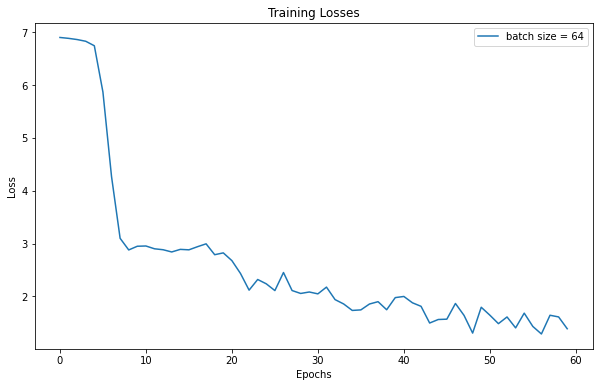

In [ ]:
# Plot the training for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(train_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

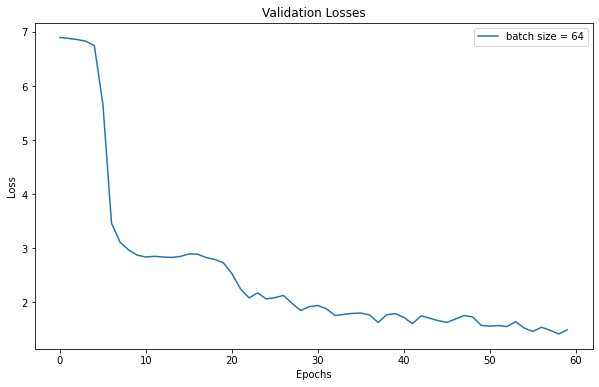

In [ ]:
# Plot the validation for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(valid_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

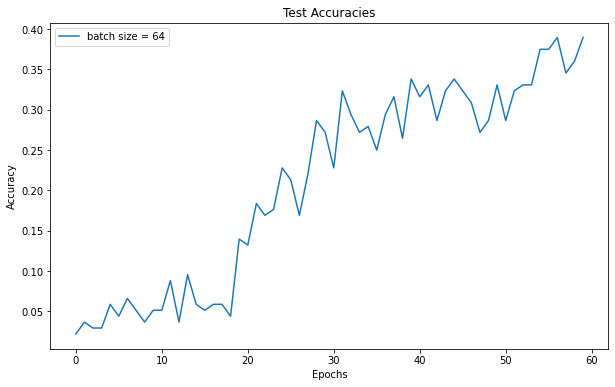

In [ ]:
# Plot the test accuracy for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(test_accs[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracies')
plt.legend()

In [ ]:
!mkdir AlexNet_result

In [ ]:
# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_64': train_losses[0]})
valid_lossespd = pd.DataFrame({'batch_size_64': valid_losses[0]})
test_accspd = pd.DataFrame({'batch_size_64': test_accs[0]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./AlexNet_result/train_losses.csv', index=True)
valid_lossespd.to_csv('./AlexNet_result/valid_losses.csv', index=True)
test_accspd.to_csv('./AlexNet_result/test_accs.csv', index=True)

In [ ]:
# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_4': train_losses[0], 'batch_size_32': train_losses[1], 'batch_size_64': train_losses[2]})
valid_lossespd = pd.DataFrame({'batch_size_4': valid_losses[0], 'batch_size_32': valid_losses[1], 'batch_size_64': valid_losses[2]})
test_accspd = pd.DataFrame({'batch_size_4': test_accs[0], 'batch_size_32': test_accs[1], 'batch_size_64': test_accs[2]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./ResNet50_result/train_losses.csv', index=True)
valid_lossespd.to_csv('./ResNet50_result/valid_losses.csv', index=True)
test_accspd.to_csv('./ResNet50_result/test_accs.csv', index=True)

IndexError: ignored

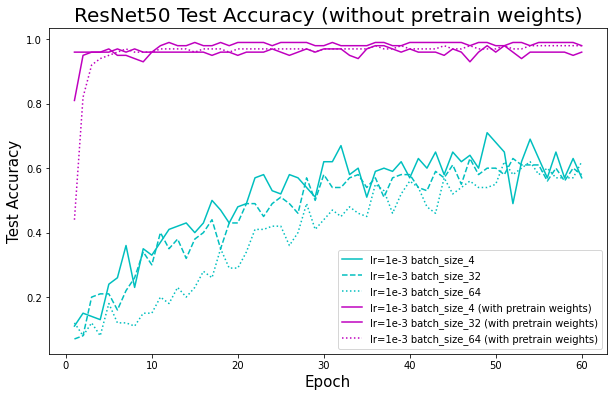

In [ ]:
import matplotlib.pyplot as plt
import csv
  
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []

x4 = []
y4 = []
x5 = []
y5 = []
x6 = []
y6 = []
  
with open('test_accs.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in lines:
      if i == 0:
        i += 1
        continue
      else:
        i += 1
        x1.append(int(row[0])+1)
        y1.append(round(float(row[1]), 2))

        x2.append(int(row[0])+1)
        y2.append(round(float(row[2]), 2))

        x3.append(int(row[0])+1)
        y3.append(round(float(row[3]), 2))

with open('test_accs_3.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in lines:
      if i == 0:
        i += 1
        continue
      else:
        i += 1
        x4.append(int(row[0])+1)
        y4.append(round(float(row[1]), 2))

        x5.append(int(row[0])+1)
        y5.append(round(float(row[2]), 2))

        x6.append(int(row[0])+1)
        y6.append(round(float(row[3]), 2))
  
# with open('test_accs_vgg16.csv','r') as csvfile:
#     lines = csv.reader(csvfile, delimiter=',')
#     i = 0
#     for row in lines:
#       if i == 0:
#         i += 1
#         continue
#       else:
#         i += 1
#         x2.append(int(row[0])+1)
#         y2.append(round(float(row[1]), 2))

# with open('test_accs_vgg19.csv','r') as csvfile:
#     lines = csv.reader(csvfile, delimiter=',')
#     i = 0
#     for row in lines:
#       if i == 0:
#         i += 1
#         continue
#       else:
#         i += 1
#         x3.append(int(row[0])+1)
#         y3.append(round(float(row[1]), 2))

# with open('test_accs_res50.csv','r') as csvfile:
#     lines = csv.reader(csvfile, delimiter=',')
#     i = 0
#     for row in lines:
#       if i == 0:
#         i += 1
#         continue
#       else:
#         i += 1
#         x4.append(int(row[0])+1)
#         y4.append(round(float(row[1]), 2))

# with open('test_accs_res101.csv','r') as csvfile:
#     lines = csv.reader(csvfile, delimiter=',')
#     i = 0
#     for row in lines:
#       if i == 0:
#         i += 1
#         continue
#       else:
#         i += 1
#         x5.append(int(row[0])+1)
#         y5.append(round(float(row[1]), 2))

      
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, color = 'c', label = "lr=1e-3 batch_size_4")
plt.plot(x2, y2, color = 'c', linestyle = 'dashed', label = "lr=1e-3 batch_size_32")
plt.plot(x3, y3, color = 'c', linestyle = 'dotted', label = "lr=1e-3 batch_size_64")
plt.plot(x4, y4, color = 'm', label = "lr=1e-3 batch_size_4 (with pretrain weights)")
plt.plot(x5, y5, color = 'm', label = "lr=1e-3 batch_size_32 (with pretrain weights)")
plt.plot(x6, y6, color = 'm', linestyle = 'dotted', label = "lr=1e-3 batch_size_64 (with pretrain weights)")
  
#plt.xticks(rotation = 25)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Test Accuracy', fontsize = 15)
plt.title('ResNet50 Test Accuracy (without pretrain weights)', fontsize = 20)
plt.legend()
plt.show()